### Import libraries

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import shap
# from captum.attr import IntegratedGradients, ShapleyValueSampling
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import math
import itertools

from models import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

In [ ]:
import pandas as pd
import numpy as np
from functions import *
from models import *
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.exceptions import ConvergenceWarning
# set default plotting parameters
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

%load_ext autoreload
%autoreload 2

# Import data

In [39]:
# read data
df = pd.read_csv('data/data.csv')

# Prepare data for training

In [ ]:
# --- Prepare dataframe ---
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
df_norm = df.copy(deep=True)
df_norm = df_norm.dropna(subset=feature_cols)  # should not drop any rows
df_norm['timestamp'] = pd.to_datetime(df_norm['timestamp'])

# drop data from 2025
df_norm = df_norm[df_norm['timestamp'] < '2025-01-01']

# Identify dummy vs. numeric columns
cat_cols = [c for c in feature_cols if c.startswith('NACE_') or c.startswith('month_')] + ['divi','divo','sin']
numeric_cols = [c for c in feature_cols if c not in cat_cols]
feature_cols = numeric_cols + cat_cols

# Prepare containers
periods = {
    '20' : '2020-01-01', 
    '21' : '2021-01-01', 
    '22' : '2022-01-01',  
    '23': '2023-01-01'
}

X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}

y_values = df_norm['target'].values.astype('float32')

for name, period in periods.items():
    period = pd.to_datetime(period)

    # --- split masks ---
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # --- extract raw feature DataFrames ---
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # --- compute winsorization bounds on TRAIN only ---
    # --- Prepare dataframe ---
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
df_norm = df.copy(deep=True)
df_norm = df_norm.dropna(subset=feature_cols)  # should not drop any rows
df_norm['timestamp'] = pd.to_datetime(df_norm['timestamp'])

# drop data from 2025
df_norm = df_norm[df_norm['timestamp'] < '2025-01-01']

# Identify dummy vs. numeric columns


# Prepare containers
periods = {
    # '20' : '2020-01-01', 
    # '21' : '2021-01-01', 
    # '22' : '2022-01-01',  
    '23': '2023-01-01'
}

X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}

y_values = df_norm['target'].values.astype('float32')

for name, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)

    # transform all splits
    X_train[name] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[name]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[name]  = preprocessor.transform(X_te_df).astype('float32')

    # store targets as before
    y_train[name] = y_tr.reshape(-1, 1)
    y_val[name]   = y_va.reshape(-1, 1)
    y_test[name]  = y_te.reshape(-1, 1)

    preprocessors[name] = preprocessor

In [41]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 4 # only hidden, excluding in- and output layers
hidden_width = [32,16,8,4] # int for all being equal width; list for different widths
learning_rate = 1e-4 # increased from 1e-4 as we have full batching
activation_fun = nn.ReLU # # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-3 # 1e-3 # currently 0 
weight_decay = 1e-3 # l2 regularization
dropout = 0.2

# general parmeters
patience = 250
print_freq = 250
epochs = 250
batch_size = 4096 # 8192 # 16384 # 2^1X adjust to your memory


Using device: mps


# Train the model

In [42]:
best_models = {}
history = {}
models = {}
preds = {}

for name, period in periods.items():
    np.random.seed(42)
    torch.manual_seed(42)
    print(f"Training model for year '{name}...")
    input_dim = X_train[name].shape[1]
    models[name] = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
    optimizer = torch.optim.AdamW(models[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
    train = MLPdataset(X_train[name], y_train[name])
    val = MLPdataset(X_val[name], y_val[name])
    best_models[name], history[name] = train_mlp(train,          
                                                val,
                                                models[name],
                                                criterion,
                                                epochs,
                                                patience,
                                                print_freq,
                                                device,
                                                optimizer,
                                                lambda_l1=lambda_l1,
                                                batch_size=batch_size,
                                                shuffle_train=True,
                                                shuffle_val=False,
                                                save_path=f'models/mlp_y{name}_l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                )
    preds[name] = predict_mlp(best_models[name],
                              X_test[name],
                              y_test[name],
                              batch_size=batch_size,
                              device=device)

Training model for year '23...
Epoch 250/250  - Train Loss: 2.78363E-02  - Val Loss: 1.29078E-02
Best val loss: 1.28807E-02
Model saved to models/mlp_y23_l10.001_l20.001_drop0.2_lr0.0001_w[32, 16, 8, 4]_d4.pth


# Graph the model

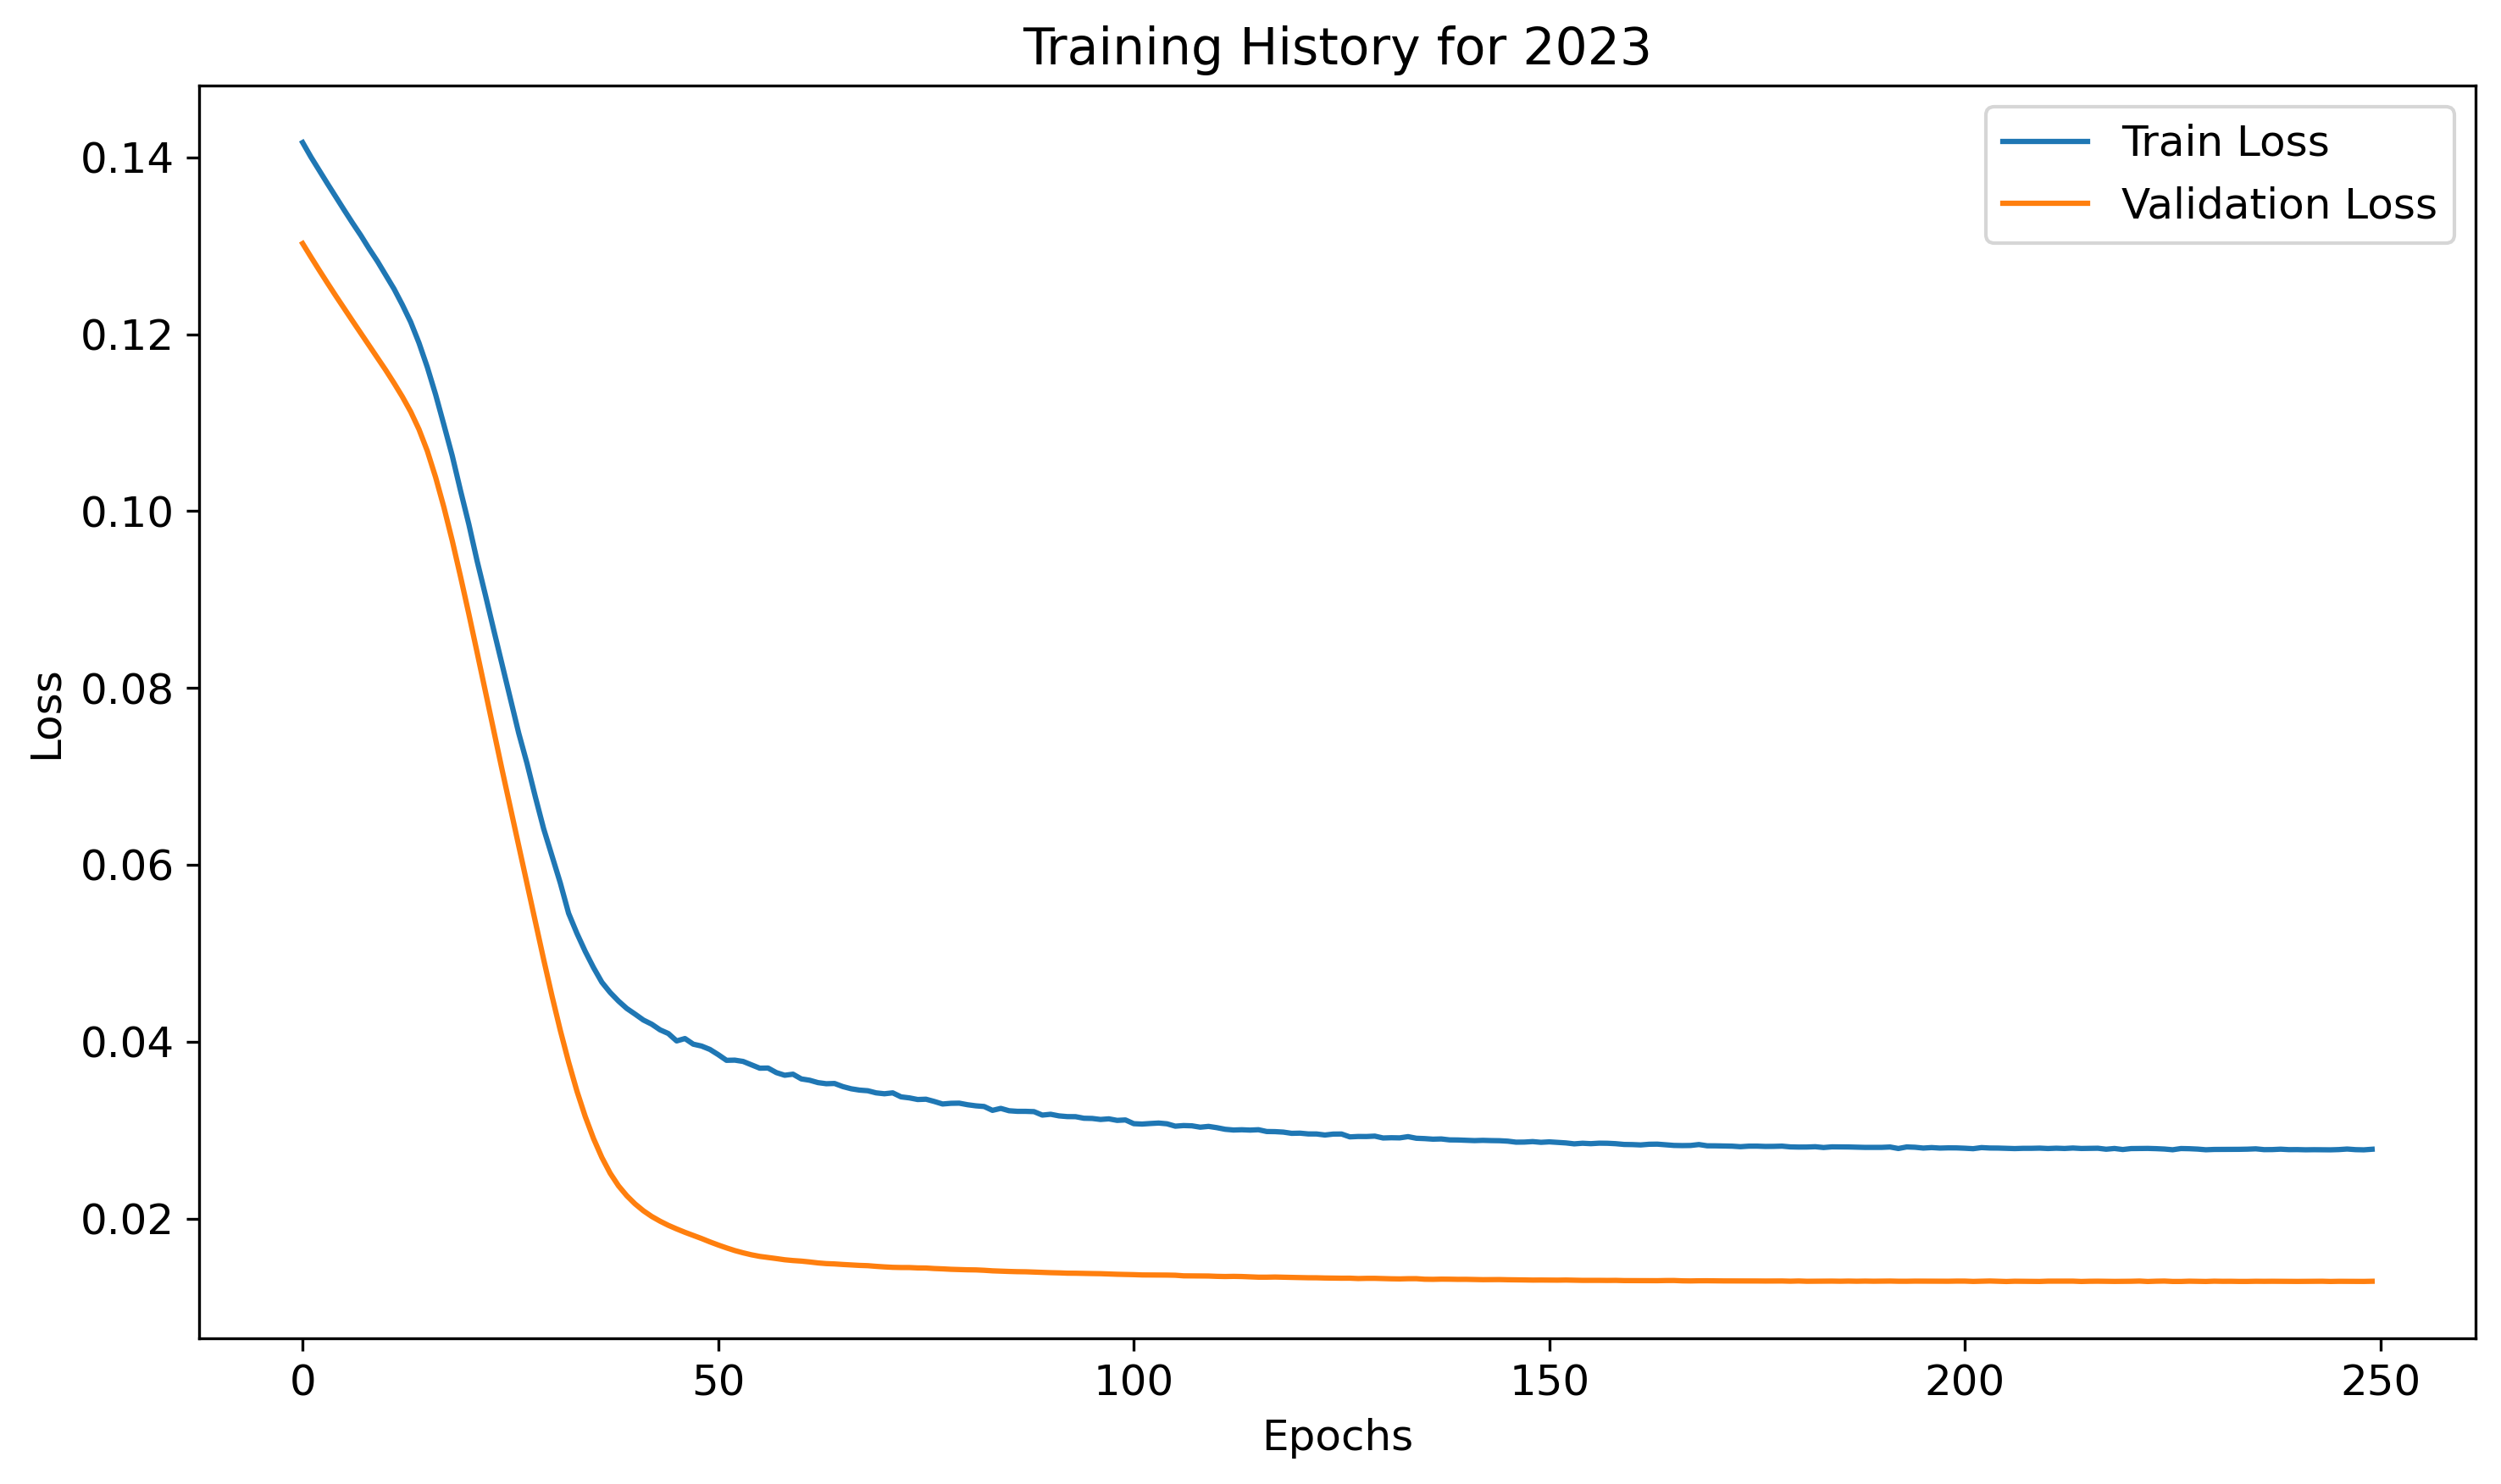

In [43]:
for name, period in periods.items():
    # plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history[name]['train_loss'], label='Train Loss')
    plt.plot(history[name]['val_loss'],   label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training History for 20{name}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

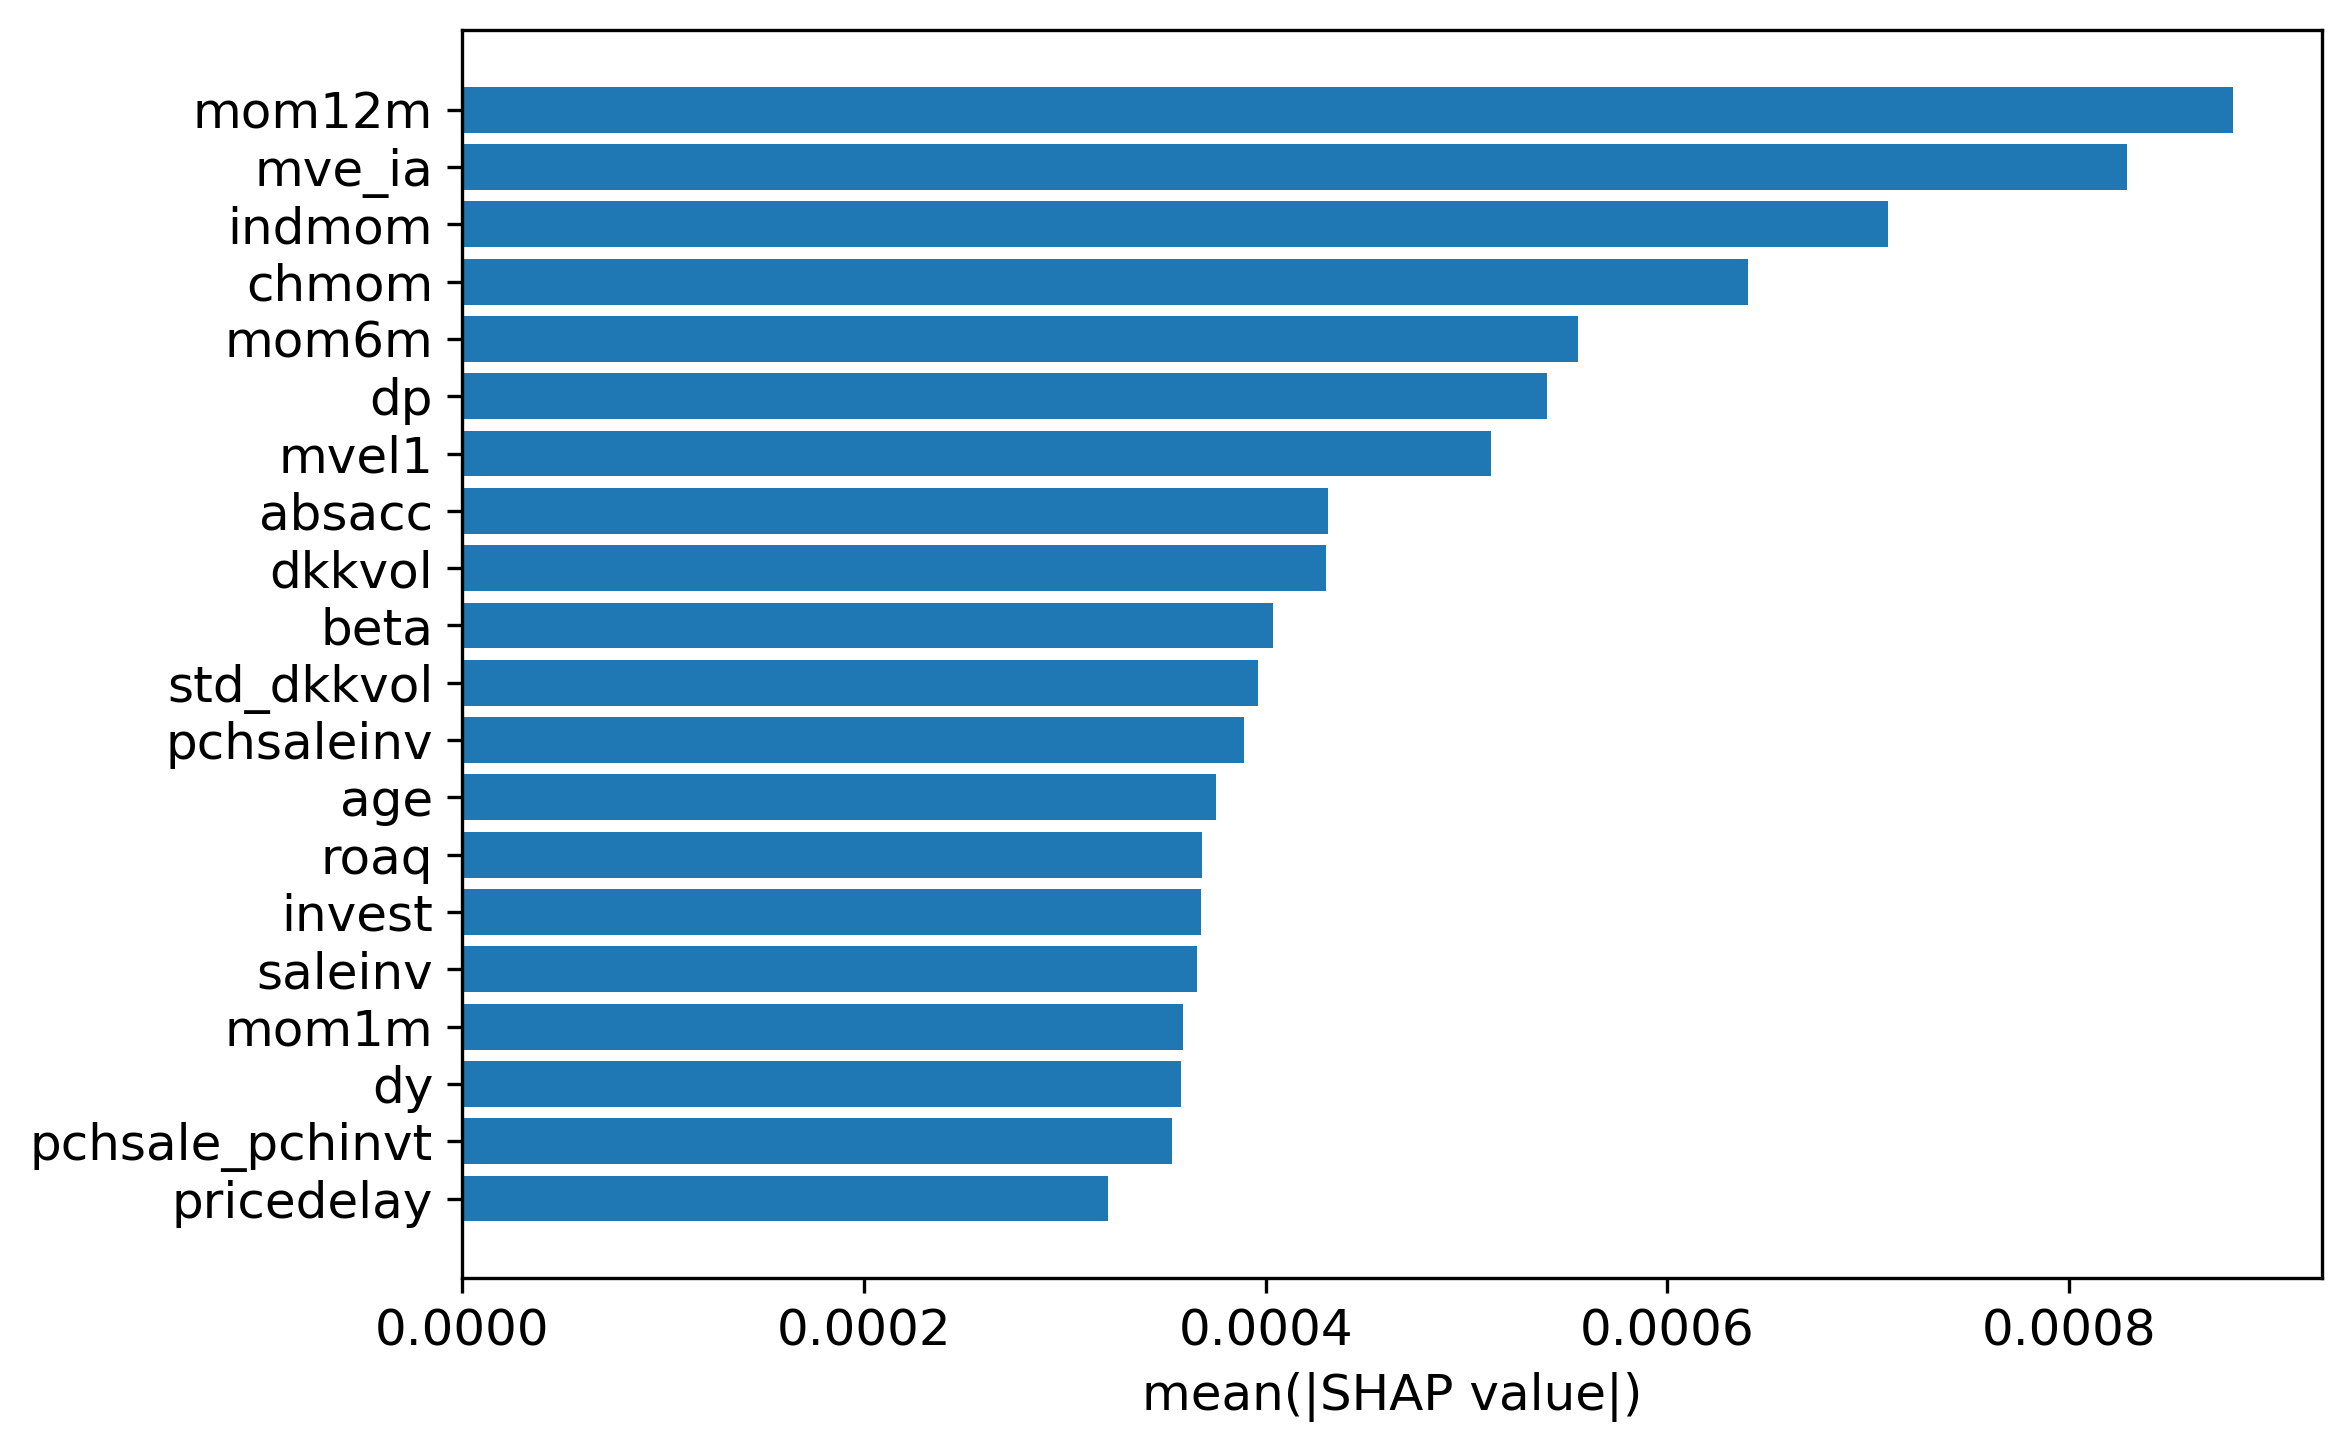

In [47]:
# --- CONFIG & RELOAD ---
period = "23"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device('cpu')
load_path = (
    f"models/mlp_y{period}"
    f"_l1{lambda_l1}"
    f"_l2{weight_decay}"
    f"_drop{dropout}"
    f"_lr{learning_rate}"
    f"_w{hidden_width}"
    f"_d{hidden_depth}.pth"
)
model = MLPModel(
    input_dim  = X_train[period].shape[1],
    depth      = hidden_depth,
    width      = hidden_width,
    dropout    = dropout,
    activation = activation_fun,
).to(device)
model.load_state_dict(torch.load(load_path, map_location=device))
model.eval()

# --- DATA TENSORS ---
X_tr_t = torch.tensor(X_train[period], dtype=torch.float32, device=device)
X_val_t = torch.tensor(X_val[period],   dtype=torch.float32, device=device)

# small background sample for SHAP
bg_size = X_tr_t.shape[0]
bg_idx  = torch.randperm(X_tr_t.shape[0], device=device)[:bg_size]
background = X_tr_t[bg_idx]   # shape (bg_size, n_features)

# --- SHAP GradientExplainer ---
explainer = shap.GradientExplainer(model, background)

raw_shap = explainer.shap_values(X_val_t)

# unwrap it: if it's a list, grab the 0th element
if isinstance(raw_shap, list) and len(raw_shap) == 1:
    raw_shap = raw_shap[0]

# raw_shap is now an ndarray of shape (n_val, n_features)
# convert to torch to aggregate
shap_t = torch.from_numpy(raw_shap).to(device)
global_shap = shap_t.abs().mean(dim=0).cpu().numpy().reshape(-1)   # shape (n_features,)

# create df and plot
df_imp = pd.DataFrame({
    "feature": feature_cols,
    "shap_importance": global_shap
})

# variables to exclude from plot
cat_macro_cols = [c for c in feature_cols if c.startswith('NACE_') or c.startswith('month_')] + ['discount','tms','ep', 'svar']
df_imp = df_imp[~df_imp["feature"].isin(cat_macro_cols)]

df_top10 = df_imp.nlargest(20, "shap_importance").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,5))
y_pos = np.arange(len(df_top10))
ax.barh(y_pos, df_top10["shap_importance"])
ax.set_yticks(y_pos)
ax.set_yticklabels(df_top10["feature"])
ax.invert_yaxis()
ax.set_xlabel("mean(|SHAP value|)")
# ax.set_title(f"Top-10 SHAP importances (period {period})")
plt.tight_layout()
plt.savefig(f"figs/shap_importance{period}.png", dpi=300)
plt.show()


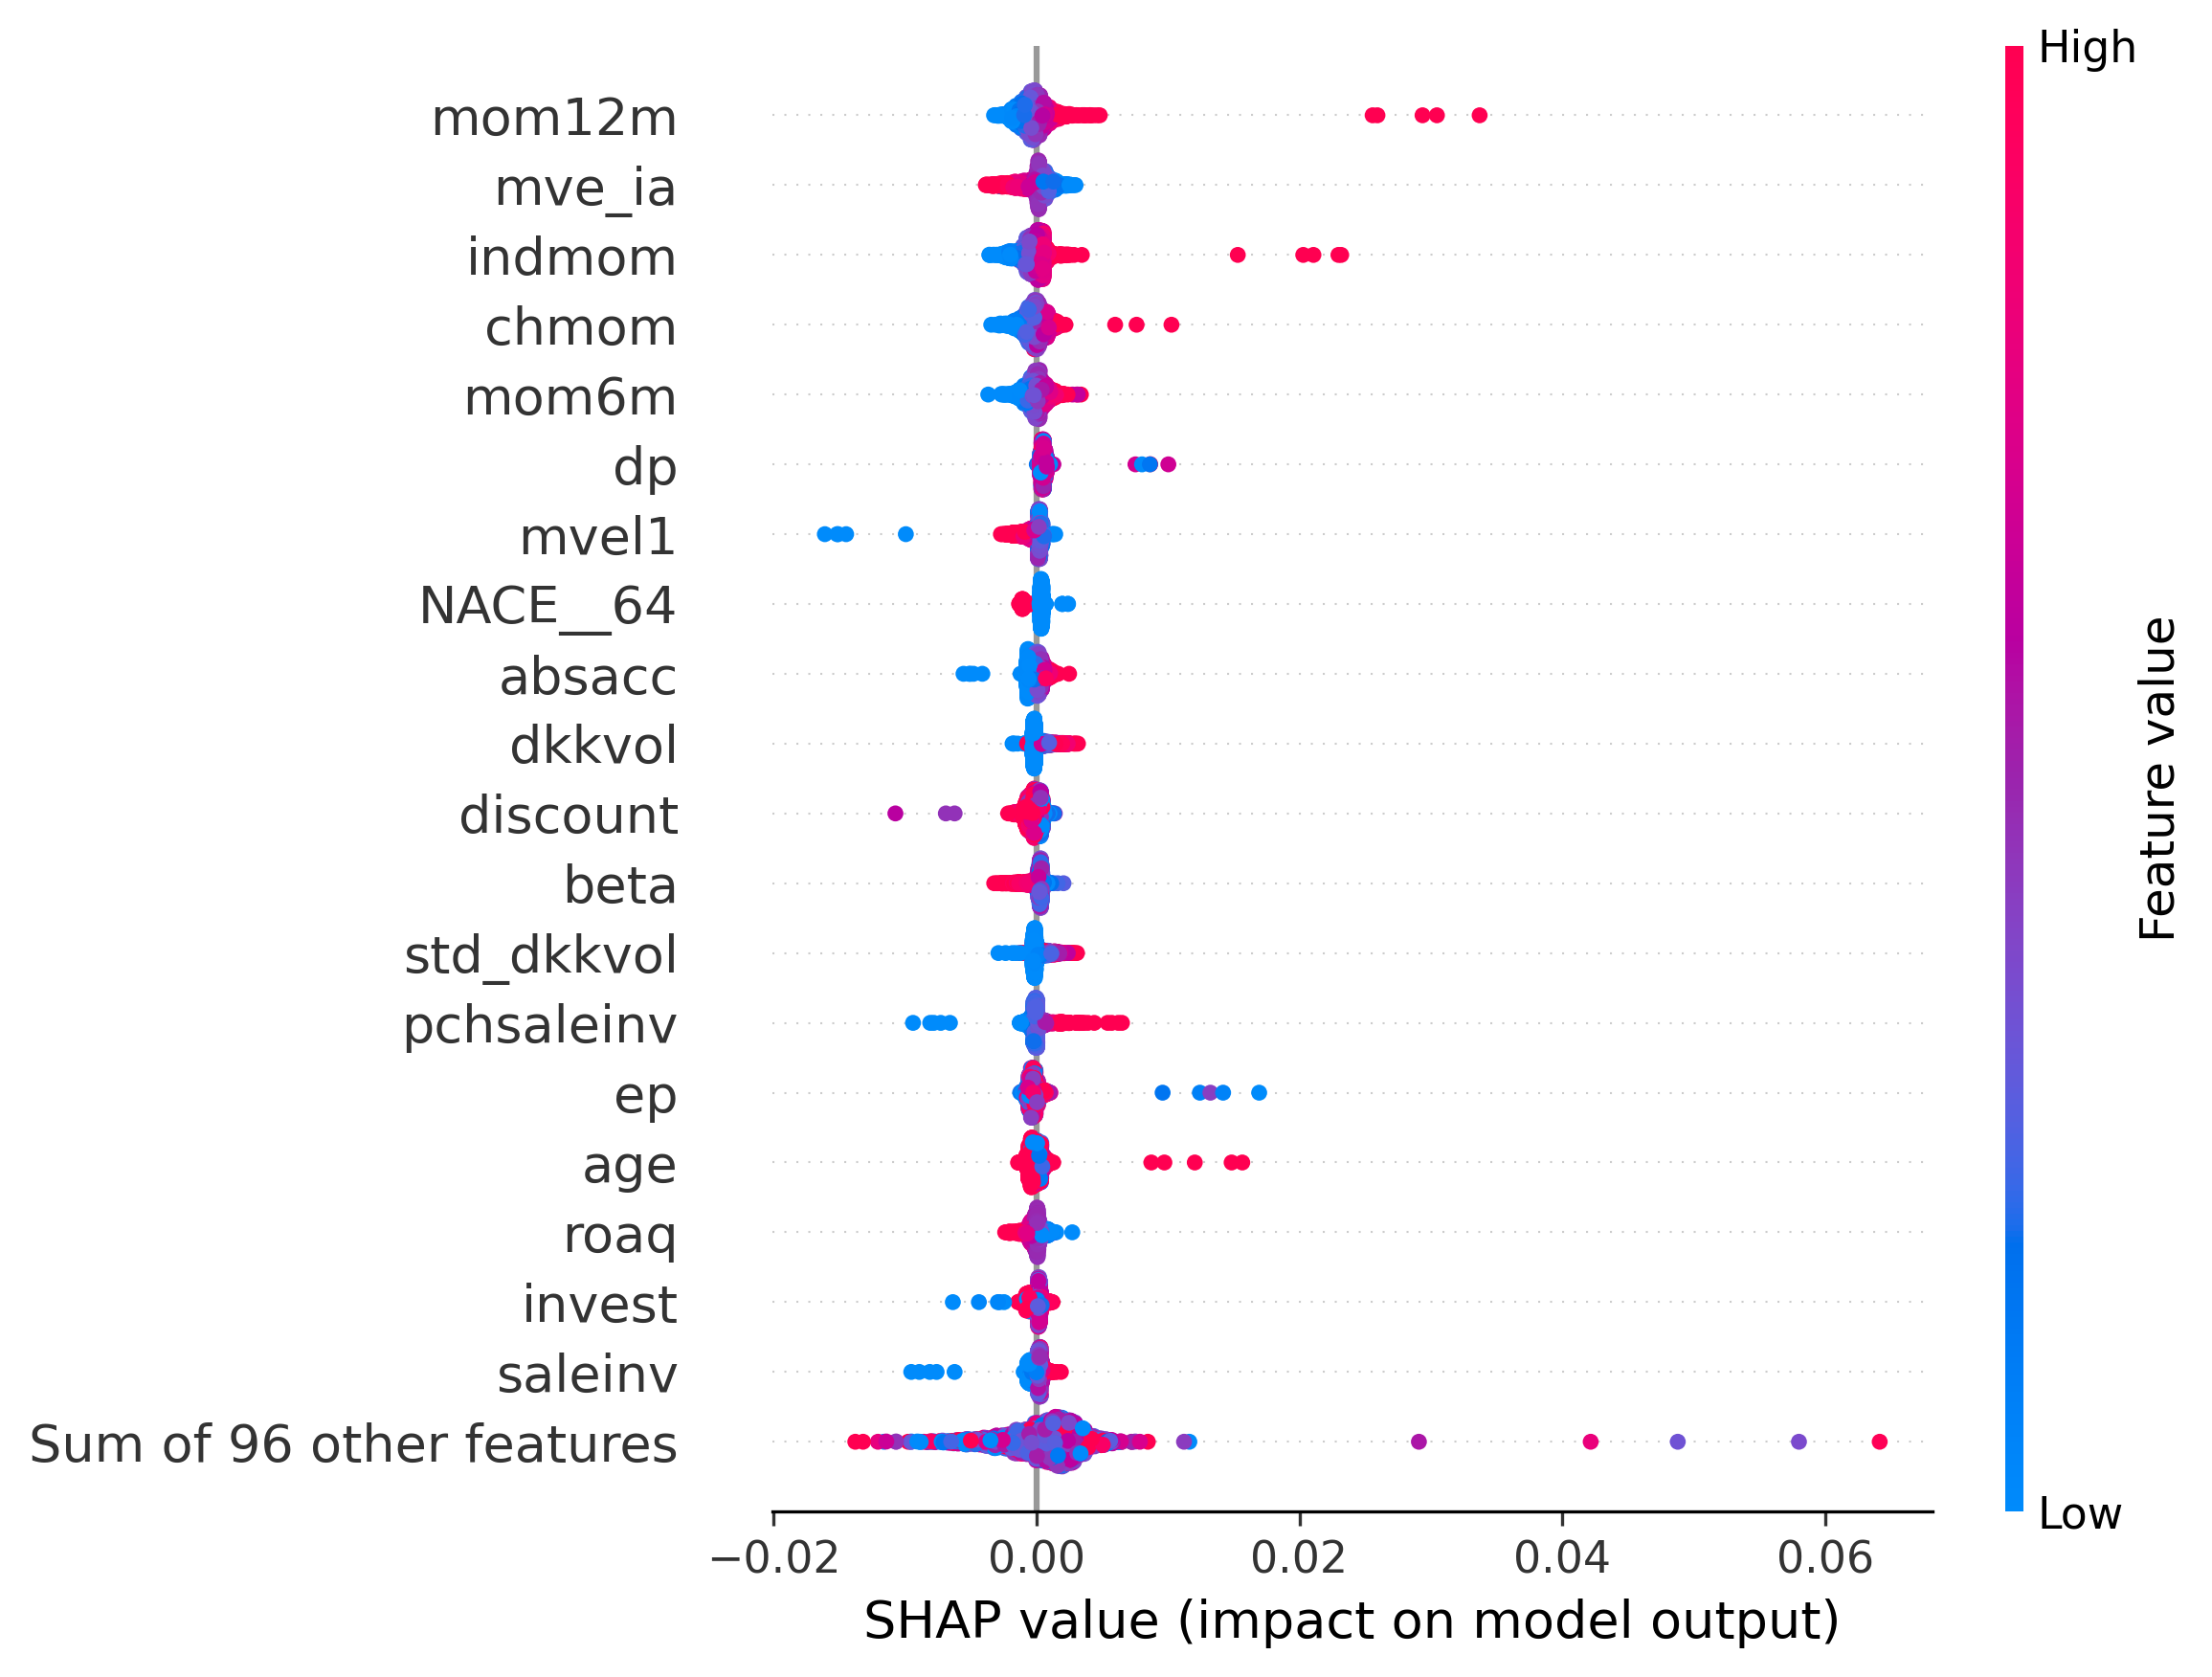

In [ ]:
# 1) Compute the base value manually
with torch.no_grad():
    preds = model(background)
    preds_flat = preds.view(preds.shape[0], -1).mean(dim=1)
    base_val = preds_flat.mean().item()

# 2) Wrap full SHAP matrix for global beeswarm
raw_shap = np.squeeze(raw_shap) 

exp_all = shap.Explanation(
    values        = raw_shap,                  # (n_val, n_features)
    base_values   = np.repeat(base_val, raw_shap.shape[0]),
    data          = X_val[period],             # numpy array or DataFrame
    feature_names = feature_cols,
)

# exclude cat_macro_cols
cat_macro_cols = [c for c in feature_cols if c.startswith('NACE_') or c.startswith('month_')] + ['discount','tms','ep', 'svar']

# 3) Plot the beeswarm
shap.plots.beeswarm(exp_all, max_display=20, show=False, plot_size=(8, 6))
plt.tight_layout()
plt.savefig(f'figs/beeswarm{period}.png', dpi=300, bbox_inches='tight')
plt.show()


<Axes: xlabel='SHAP value (impact on model output)'>

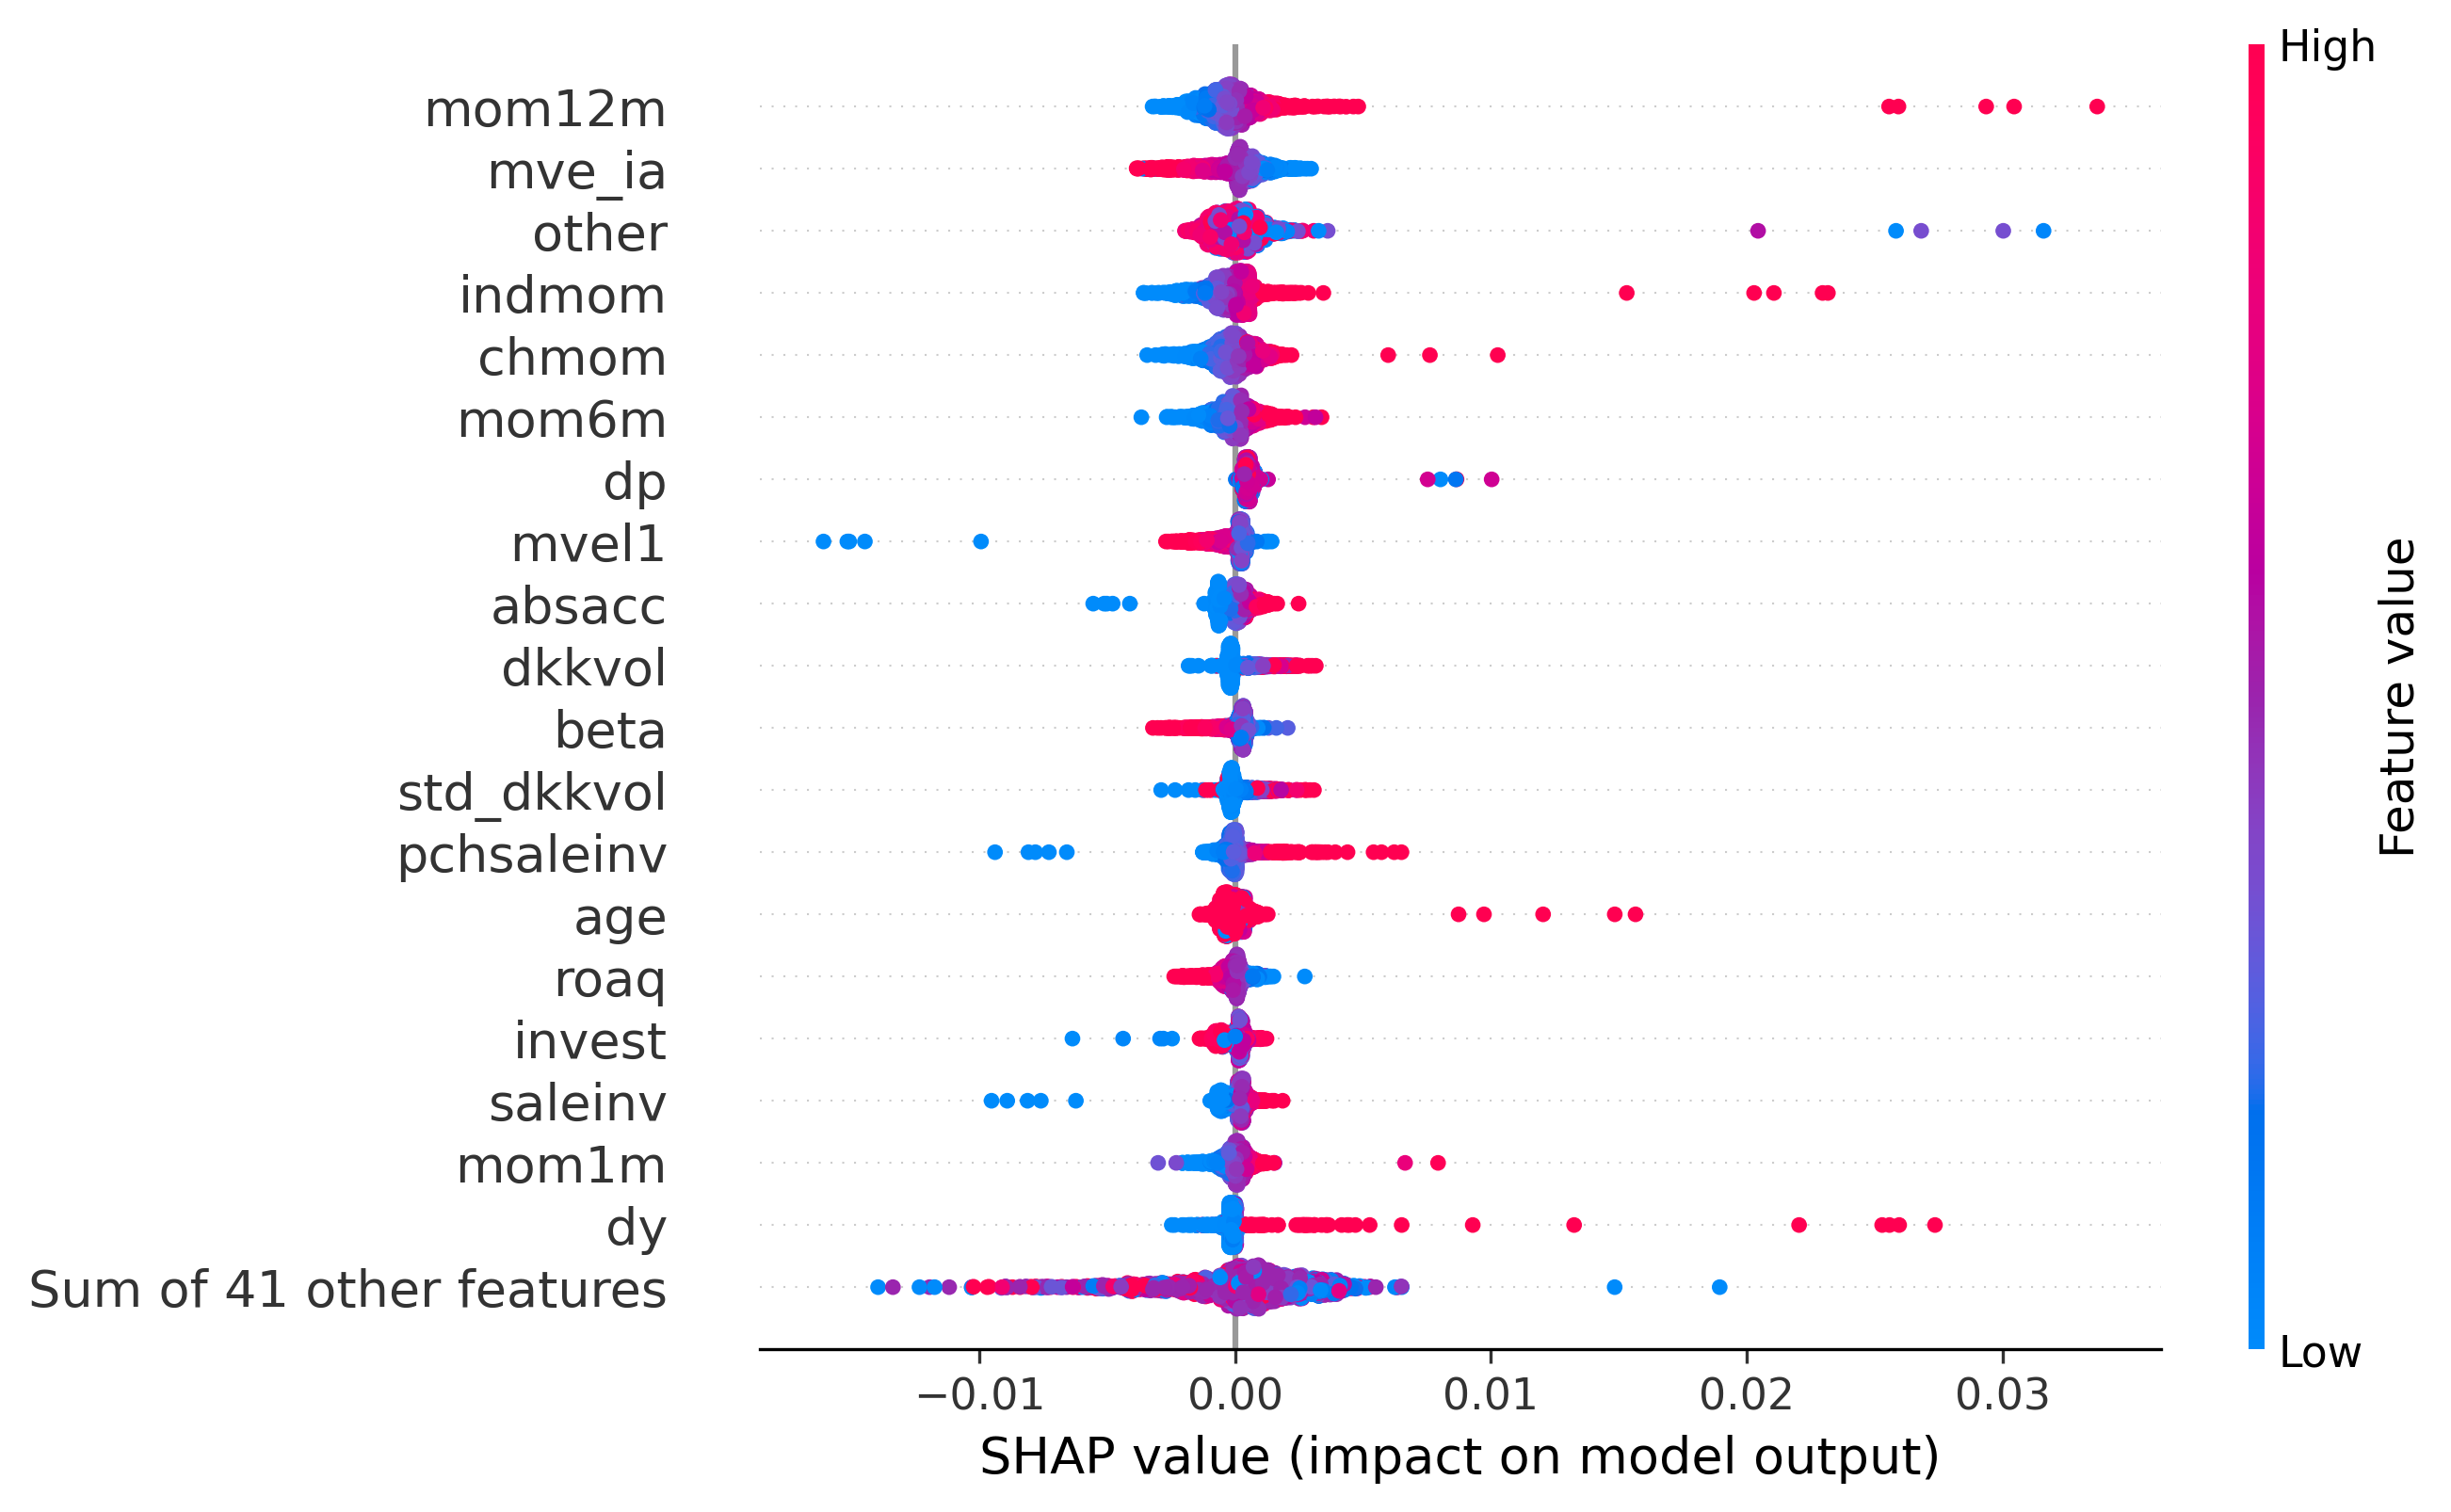

In [50]:
# 1) define which to group
cat_macro_cols = [c for c in feature_cols
                  if c.startswith('NACE_') or c.startswith('month_')] \
                  + ['discount','tms','ep','svar']

# 2) split out “keep” vs “other”
keep_cols  = [c for c in feature_cols if c not in cat_macro_cols]
keep_idx   = [feature_cols.index(c) for c in keep_cols]
other_idx  = [feature_cols.index(c) for c in cat_macro_cols]

# 3) build new SHAP‐matrix with an extra “other” column
shap_keep  = raw_shap[:, keep_idx]                            # shape (n_val, n_keep)
shap_other = raw_shap[:, other_idx].sum(axis=1, keepdims=True)  # shape (n_val, 1)
values_grp = np.hstack([shap_keep, shap_other])               # shape (n_val, n_keep+1)

# 5) new feature names
feat_grp = keep_cols + ["other"]

data_arr     = X_val[period]                             # shape (n_val, n_features), numpy array
data_keep    = data_arr[:, keep_idx]                     # (n_val, n_keep)
data_other   = data_arr[:, other_idx].sum(axis=1, keepdims=True)  # (n_val, 1)
data_grp     = np.hstack([data_keep, data_other])        # (n_val, n_keep+1)

# then feed data_grp into the Explanation:
exp_grp = shap.Explanation(
    values        = values_grp,                          # from before
    base_values   = np.repeat(base_val, values_grp.shape[0]),
    data          = data_grp,
    feature_names = feat_grp,
)
shap.plots.beeswarm(exp_grp, max_display=20, show=False, plot_size=(8,6))


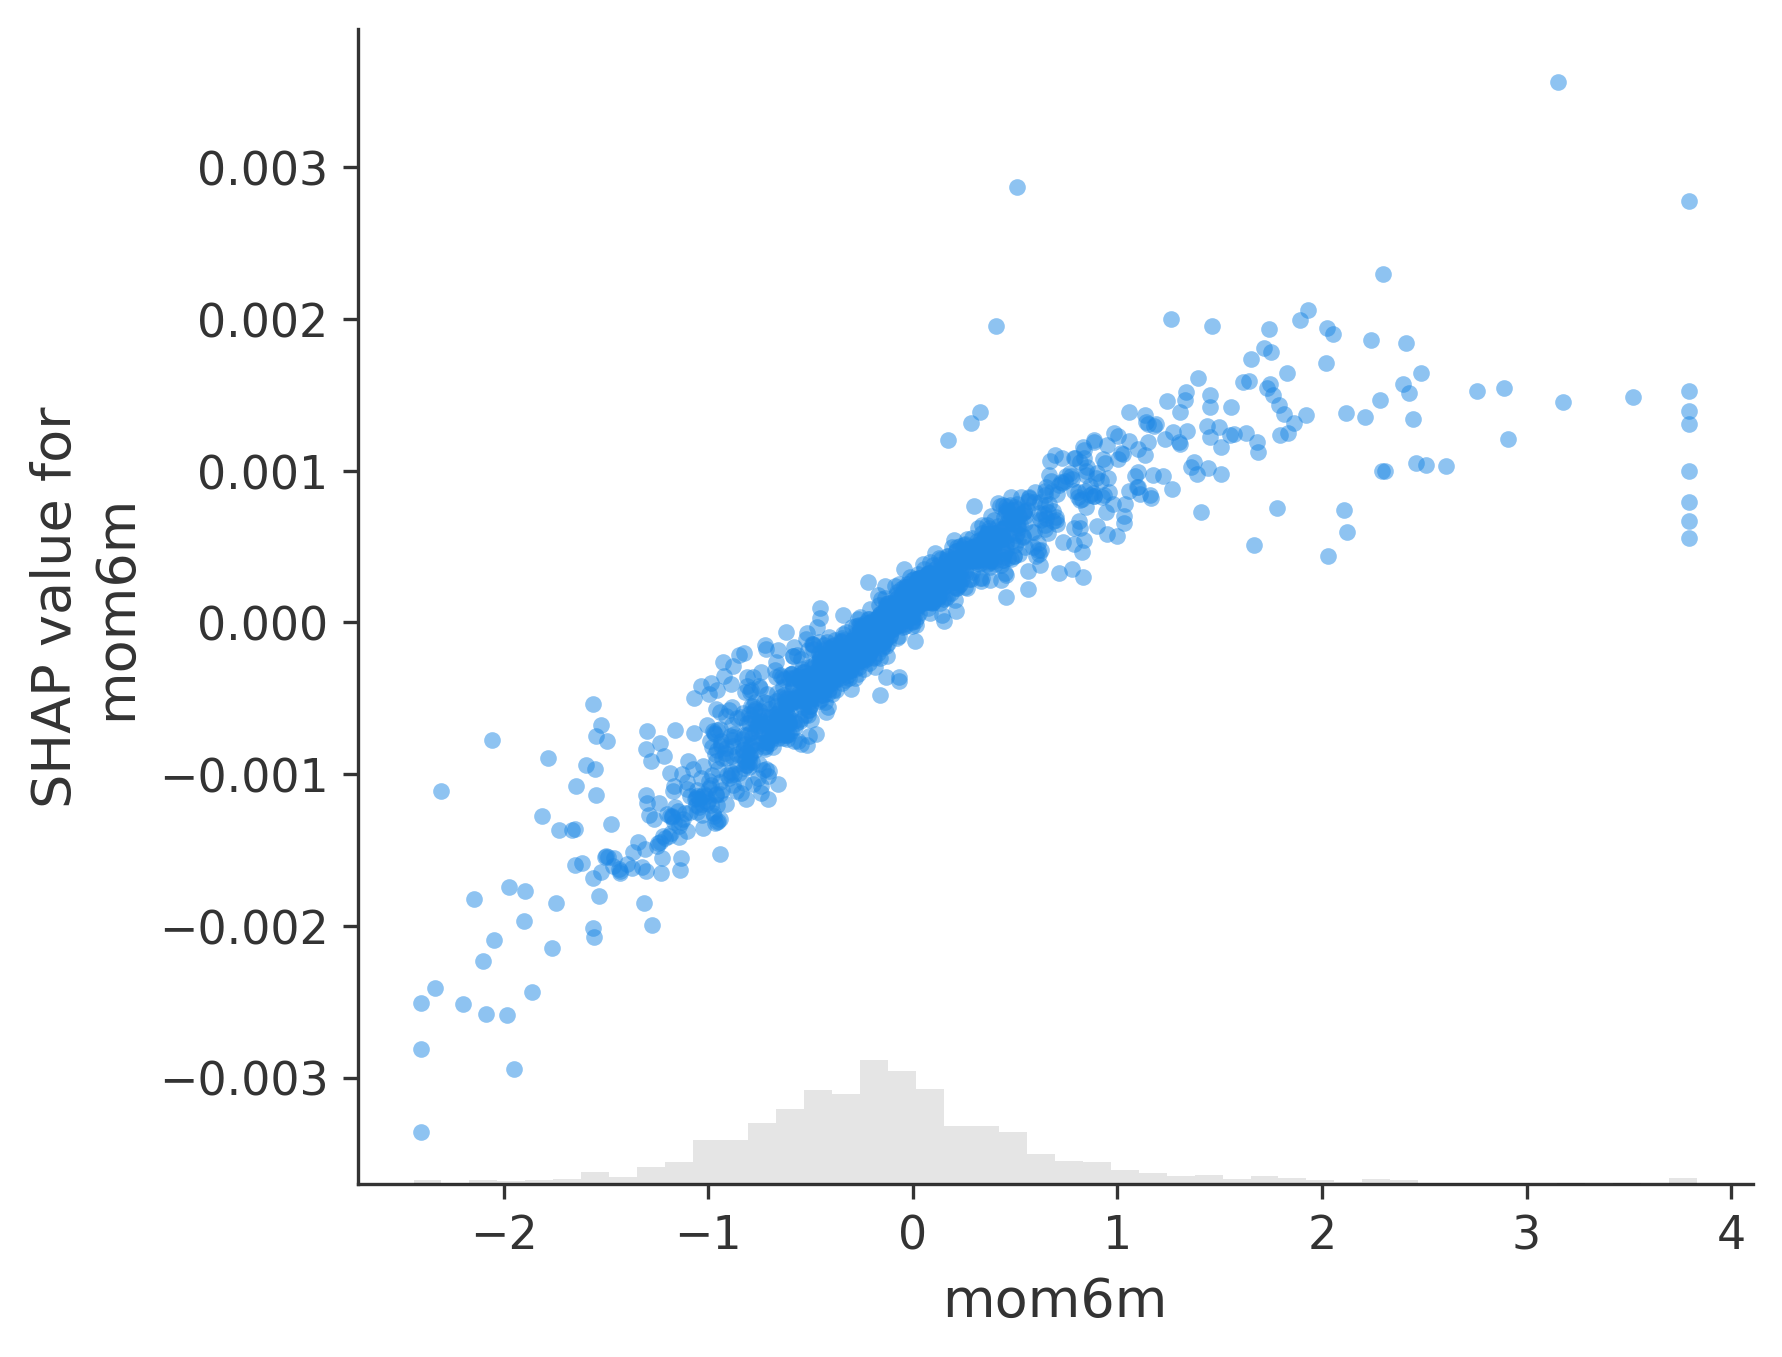

In [37]:
feature_name = "mom6m"  # or any other feature name
shap.plots.scatter(
    exp_all[:, feature_name],    # e.g. exp_all[:, "age"]
    # color=exp_all[:, "age"],     # color by itself or by another feature
    alpha=0.5,
    show=True,
)


# Test hyperparameters

In [10]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-3] # [0.0]
weight_decay_space = [0.0, 1e-3] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [dropout] # [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [1, 2, 3, 4, 5, 6, 7, 8] # [1, 2, 3]
width_space = [8, 16, 32, 64, 128, 256] # [32, 64, 128]

In [ ]:
# current runtime: 4h 35m

best_models_23 = {}
history_23 = {}
models_23 = {}
year = '23'

for weight_decay in weight_decay_space:
    for dropout in dropout_space:
        for lambda_l1 in l1_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        np.random.seed(42)
                        torch.manual_seed(42)
                        print(f"""Training model for year '23: 
                                lambda_l1       ={lambda_l1:.0e}
                                weight_decay    ={weight_decay:.0e}
                                dropout         ={dropout:.0e}
                                learning_rate   ={learning_rate:.0e}
                                hidden_depth    ={hidden_depth}
                                hidden_width    ={hidden_width}""")
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        models_23[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.AdamW(models_23[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_23[name], history_23[name] = train_mlp(train,          
                                                        val,
                                                        models_23[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/mlp_y23_l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                        )

Training model for year '23: 
                                lambda_l1       =0e+00
                                weight_decay    =0e+00
                                dropout         =2e-01
                                learning_rate   =1e-04
                                hidden_depth    =1
                                hidden_width    =8
Epoch 250/250  - Train Loss: 2.81447E-02  - Val Loss: 1.46147E-02
Best val loss: 1.46147E-02
Model saved to models/mlp_y23_l10.0_l20.0_drop0.2_lr0.0001_w8_d1.pth
Training model for year '23: 
                                lambda_l1       =0e+00
                                weight_decay    =0e+00
                                dropout         =2e-01
                                learning_rate   =1e-04
                                hidden_depth    =1
                                hidden_width    =16
Epoch 250/250  - Train Loss: 2.64591E-02  - Val Loss: 1.34340E-02
Best val loss: 1.34269E-02
Model saved to models/mlp_y23_l10.0_l20.

KeyboardInterrupt: 

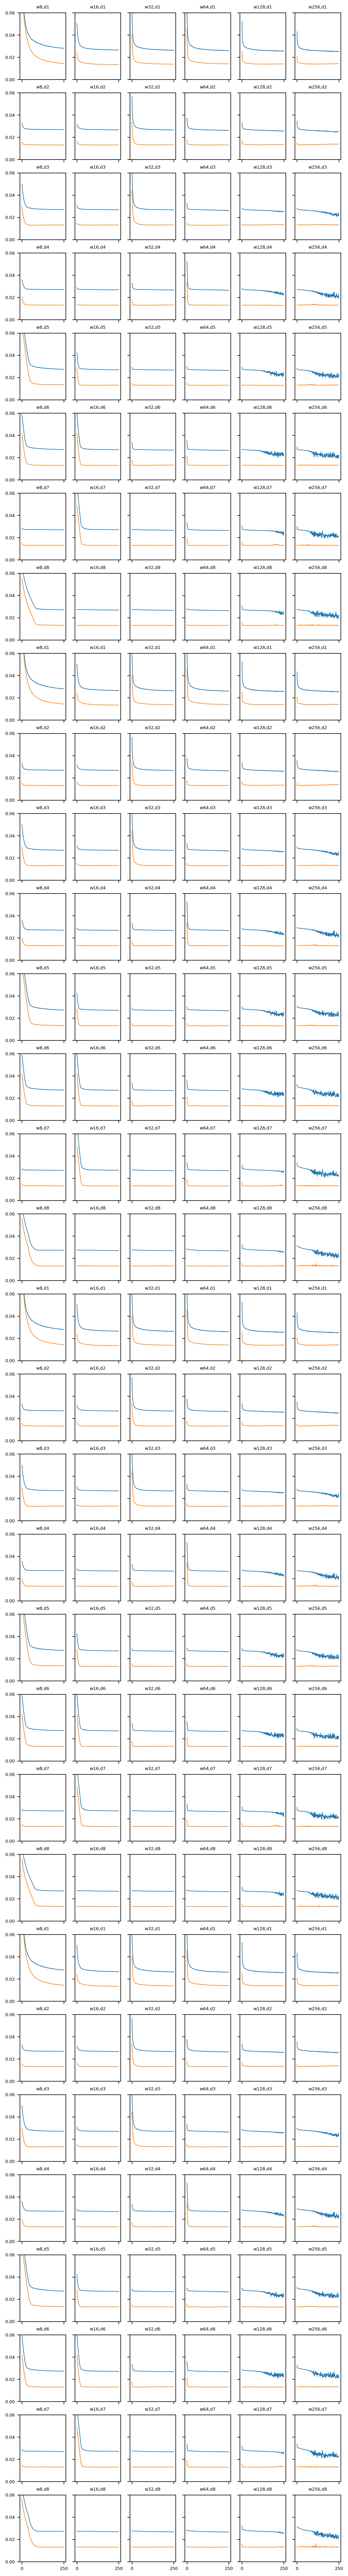

In [ ]:
# build the full list of parameter tuples
param_grid = list(itertools.product(
    weight_decay_space,
    dropout_space,
    l1_space,
    learning_rate_space,
    depth_space,
    width_space
))

n_plots = len(param_grid)                     # = 192
ncols   = 6                                   # eight columns
nrows   = math.ceil(n_plots / ncols)          # 24 rows

# each “tile” will be very short – adjust `row_height` if you want more vertical space
row_height = 2                             # inches per row
fig = plt.figure(figsize=(8, row_height * nrows))
axes = fig.subplots(nrows, ncols, sharex=True, sharey=True).flatten()

for ax, params in zip(axes, param_grid):
    weight_decay, dropout, lambda_l1, lr, hidden_depth, hidden_width = params
    name = f'l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{lr}_w{hidden_width}_d{hidden_depth}'
    hist = history_23[name]     # assuming this dict exists
    ax.plot(hist['train_loss'],  linewidth=0.8)
    ax.plot(hist['val_loss'],    linewidth=0.8)
    ax.set_title(f"w{hidden_width},d{hidden_depth}", fontsize=6)
    ax.label_outer()            # only show outer tick labels

for ax in axes[len(param_grid):]:
    ax.set_visible(False)

# adjust the font size of the x/y ticks
for ax in axes:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(6)


for ax in axes:
    ax.set_ylim(0, 0.06)
# add a single legend and suptitle
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=8)
# fig.suptitle("All Training/Validation Losses (8-column layout)", y=1.02, fontsize=10)

# plt.tight_layout()
plt.show()


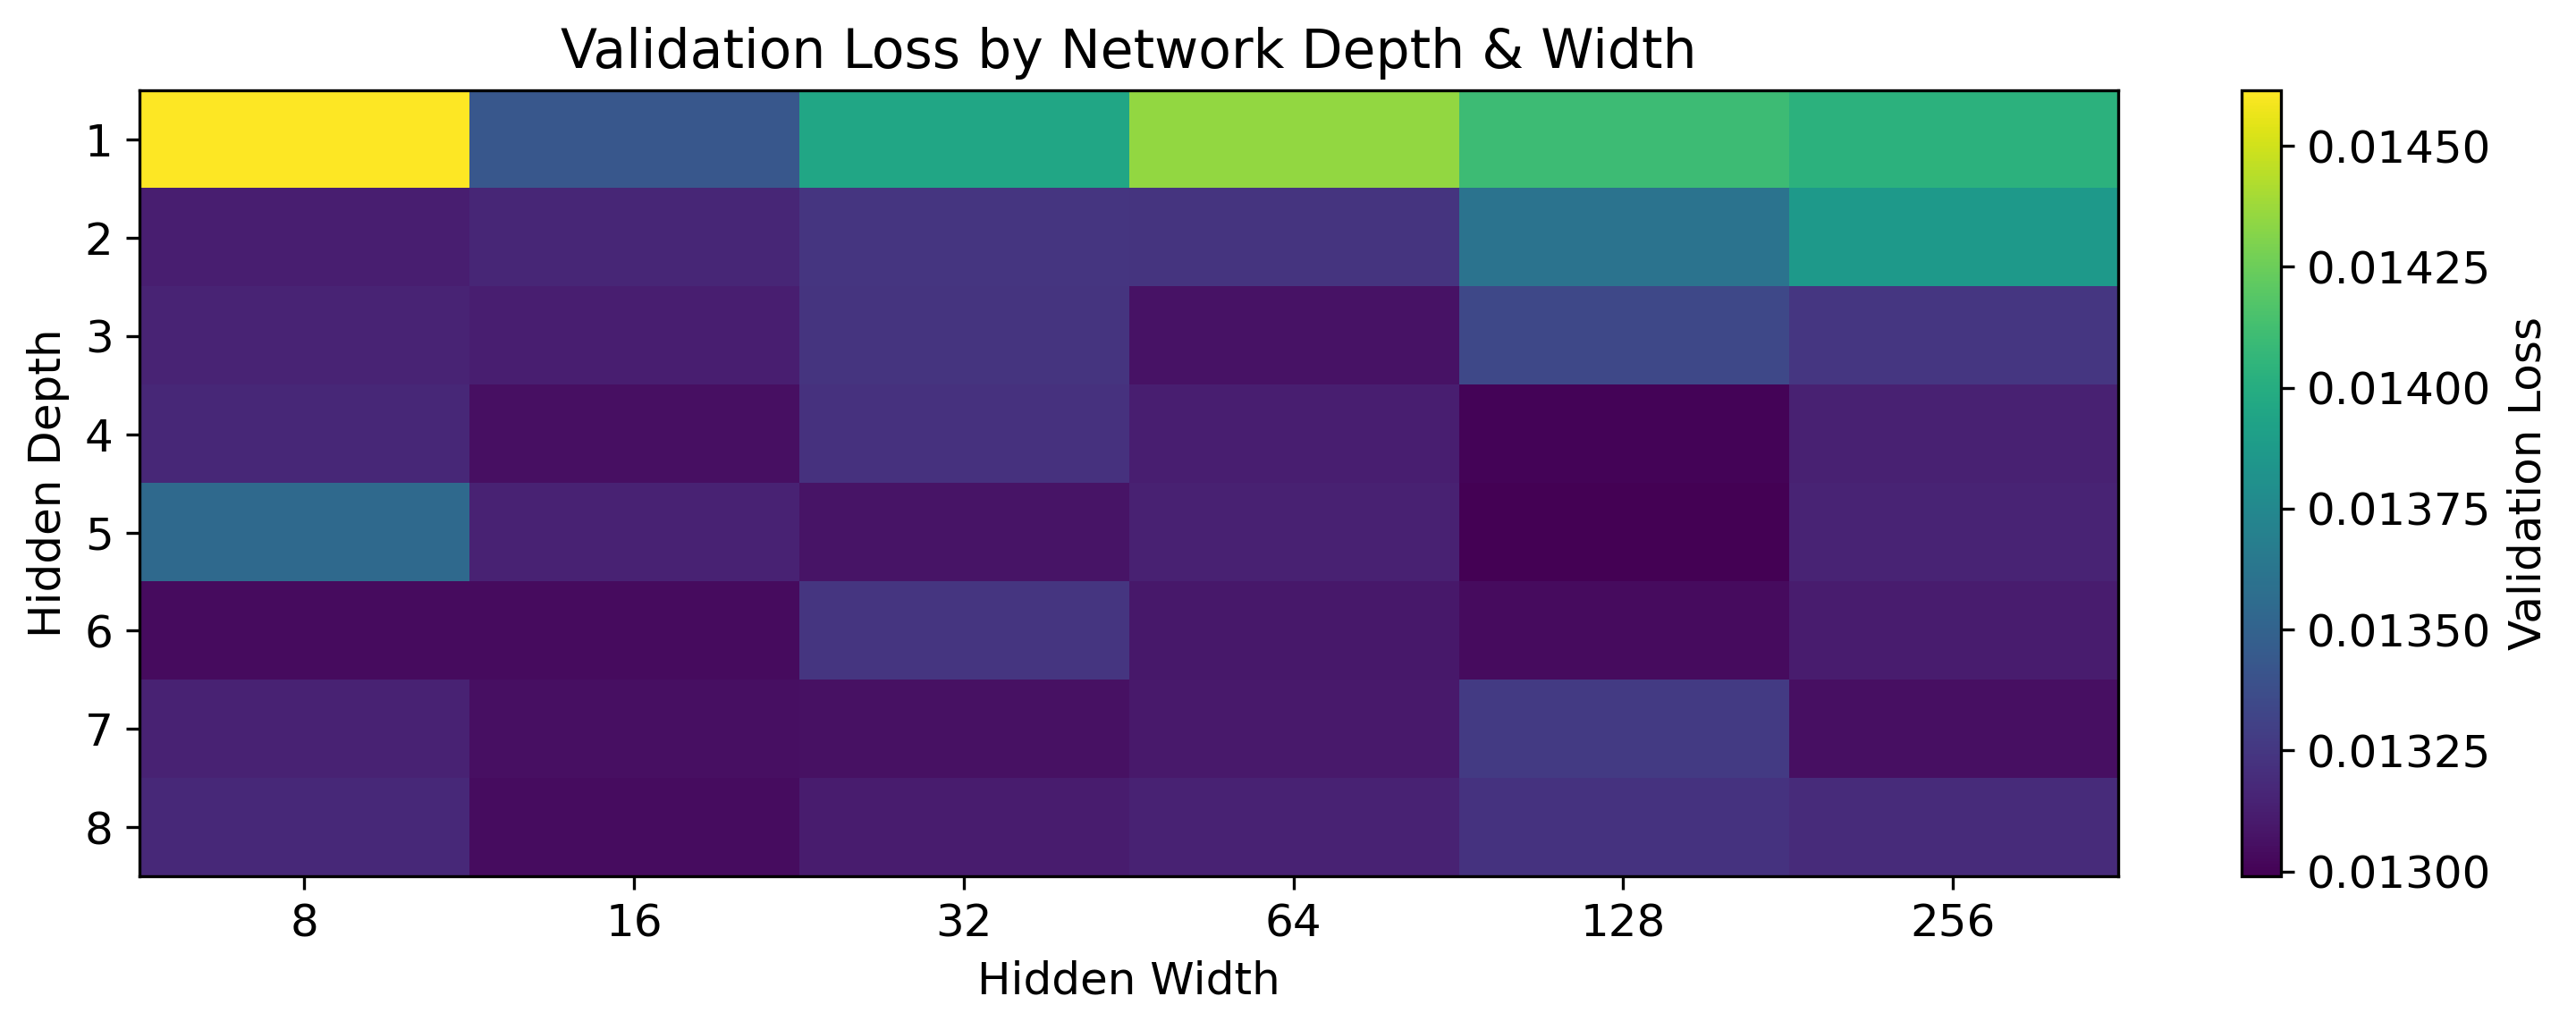

In [13]:
device = torch.device('cpu')
criterion = nn.MSELoss()
val = MLPdataset(X_val[year], y_val[year])

# load models
best_models_23 = {}

for hidden_depth in depth_space:
    for hidden_width in width_space:
        for dropout in dropout_space:
            for weight_decay in weight_decay_space:
                for lambda_l1 in l1_space:
                    for learning_rate in learning_rate_space:
                        name = f'l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        load_path = (
                            f"models/mlp_y{period}"
                            f"_l1{lambda_l1}"
                            f"_l2{weight_decay}"
                            f"_drop{dropout}"
                            f"_lr{learning_rate}"
                            f"_w{hidden_width}"
                            f"_d{hidden_depth}.pth"
                        )
                        model = MLPModel(
                            input_dim  = X_train[period].shape[1],
                            depth      = hidden_depth,
                            width      = hidden_width,
                            dropout    = dropout,
                            activation = activation_fun,
                        ).to(device)
                        model.load_state_dict(torch.load(load_path, map_location=device))
                        best_models_23[name] = model
                        model.eval()
                        # get val loss



# assume best_models_23 has been filled as in your snippet,
val_loader    = DataLoader(val, batch_size=batch_size, shuffle=False)

loss_matrix   = np.zeros((len(depth_space), len(width_space)))
val_loss_23   = {}  # overwrite or reuse your existing dict

for i, hidden_depth in enumerate(depth_space):
    for j, hidden_width in enumerate(width_space):
        # build the exact same key you used when loading
        name = f'l1{l1_space[0]}_l2{weight_decay_space[0]}' \
               f'_drop{dropout_space[0]}_lr{learning_rate_space[0]}' \
               f'_w{hidden_width}_d{hidden_depth}'
        model = best_models_23[name]
        model.eval()
        
        # compute mean validation loss for this (depth, width)
        losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                losses.append(criterion(y_pred, y_batch).item())
        mean_loss = np.mean(losses)
        
        val_loss_23[name] = mean_loss
        loss_matrix[i, j] = mean_loss

# now plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(loss_matrix, aspect='auto')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Validation Loss')

# label ticks with your hyper-param values
ax.set_xticks(np.arange(len(width_space)))
ax.set_xticklabels(width_space)
ax.set_xlabel('Hidden Width')

ax.set_yticks(np.arange(len(depth_space)))
ax.set_yticklabels(depth_space)
ax.set_ylabel('Hidden Depth')

ax.set_title('Validation Loss by Network Depth & Width')
plt.tight_layout()
plt.show()

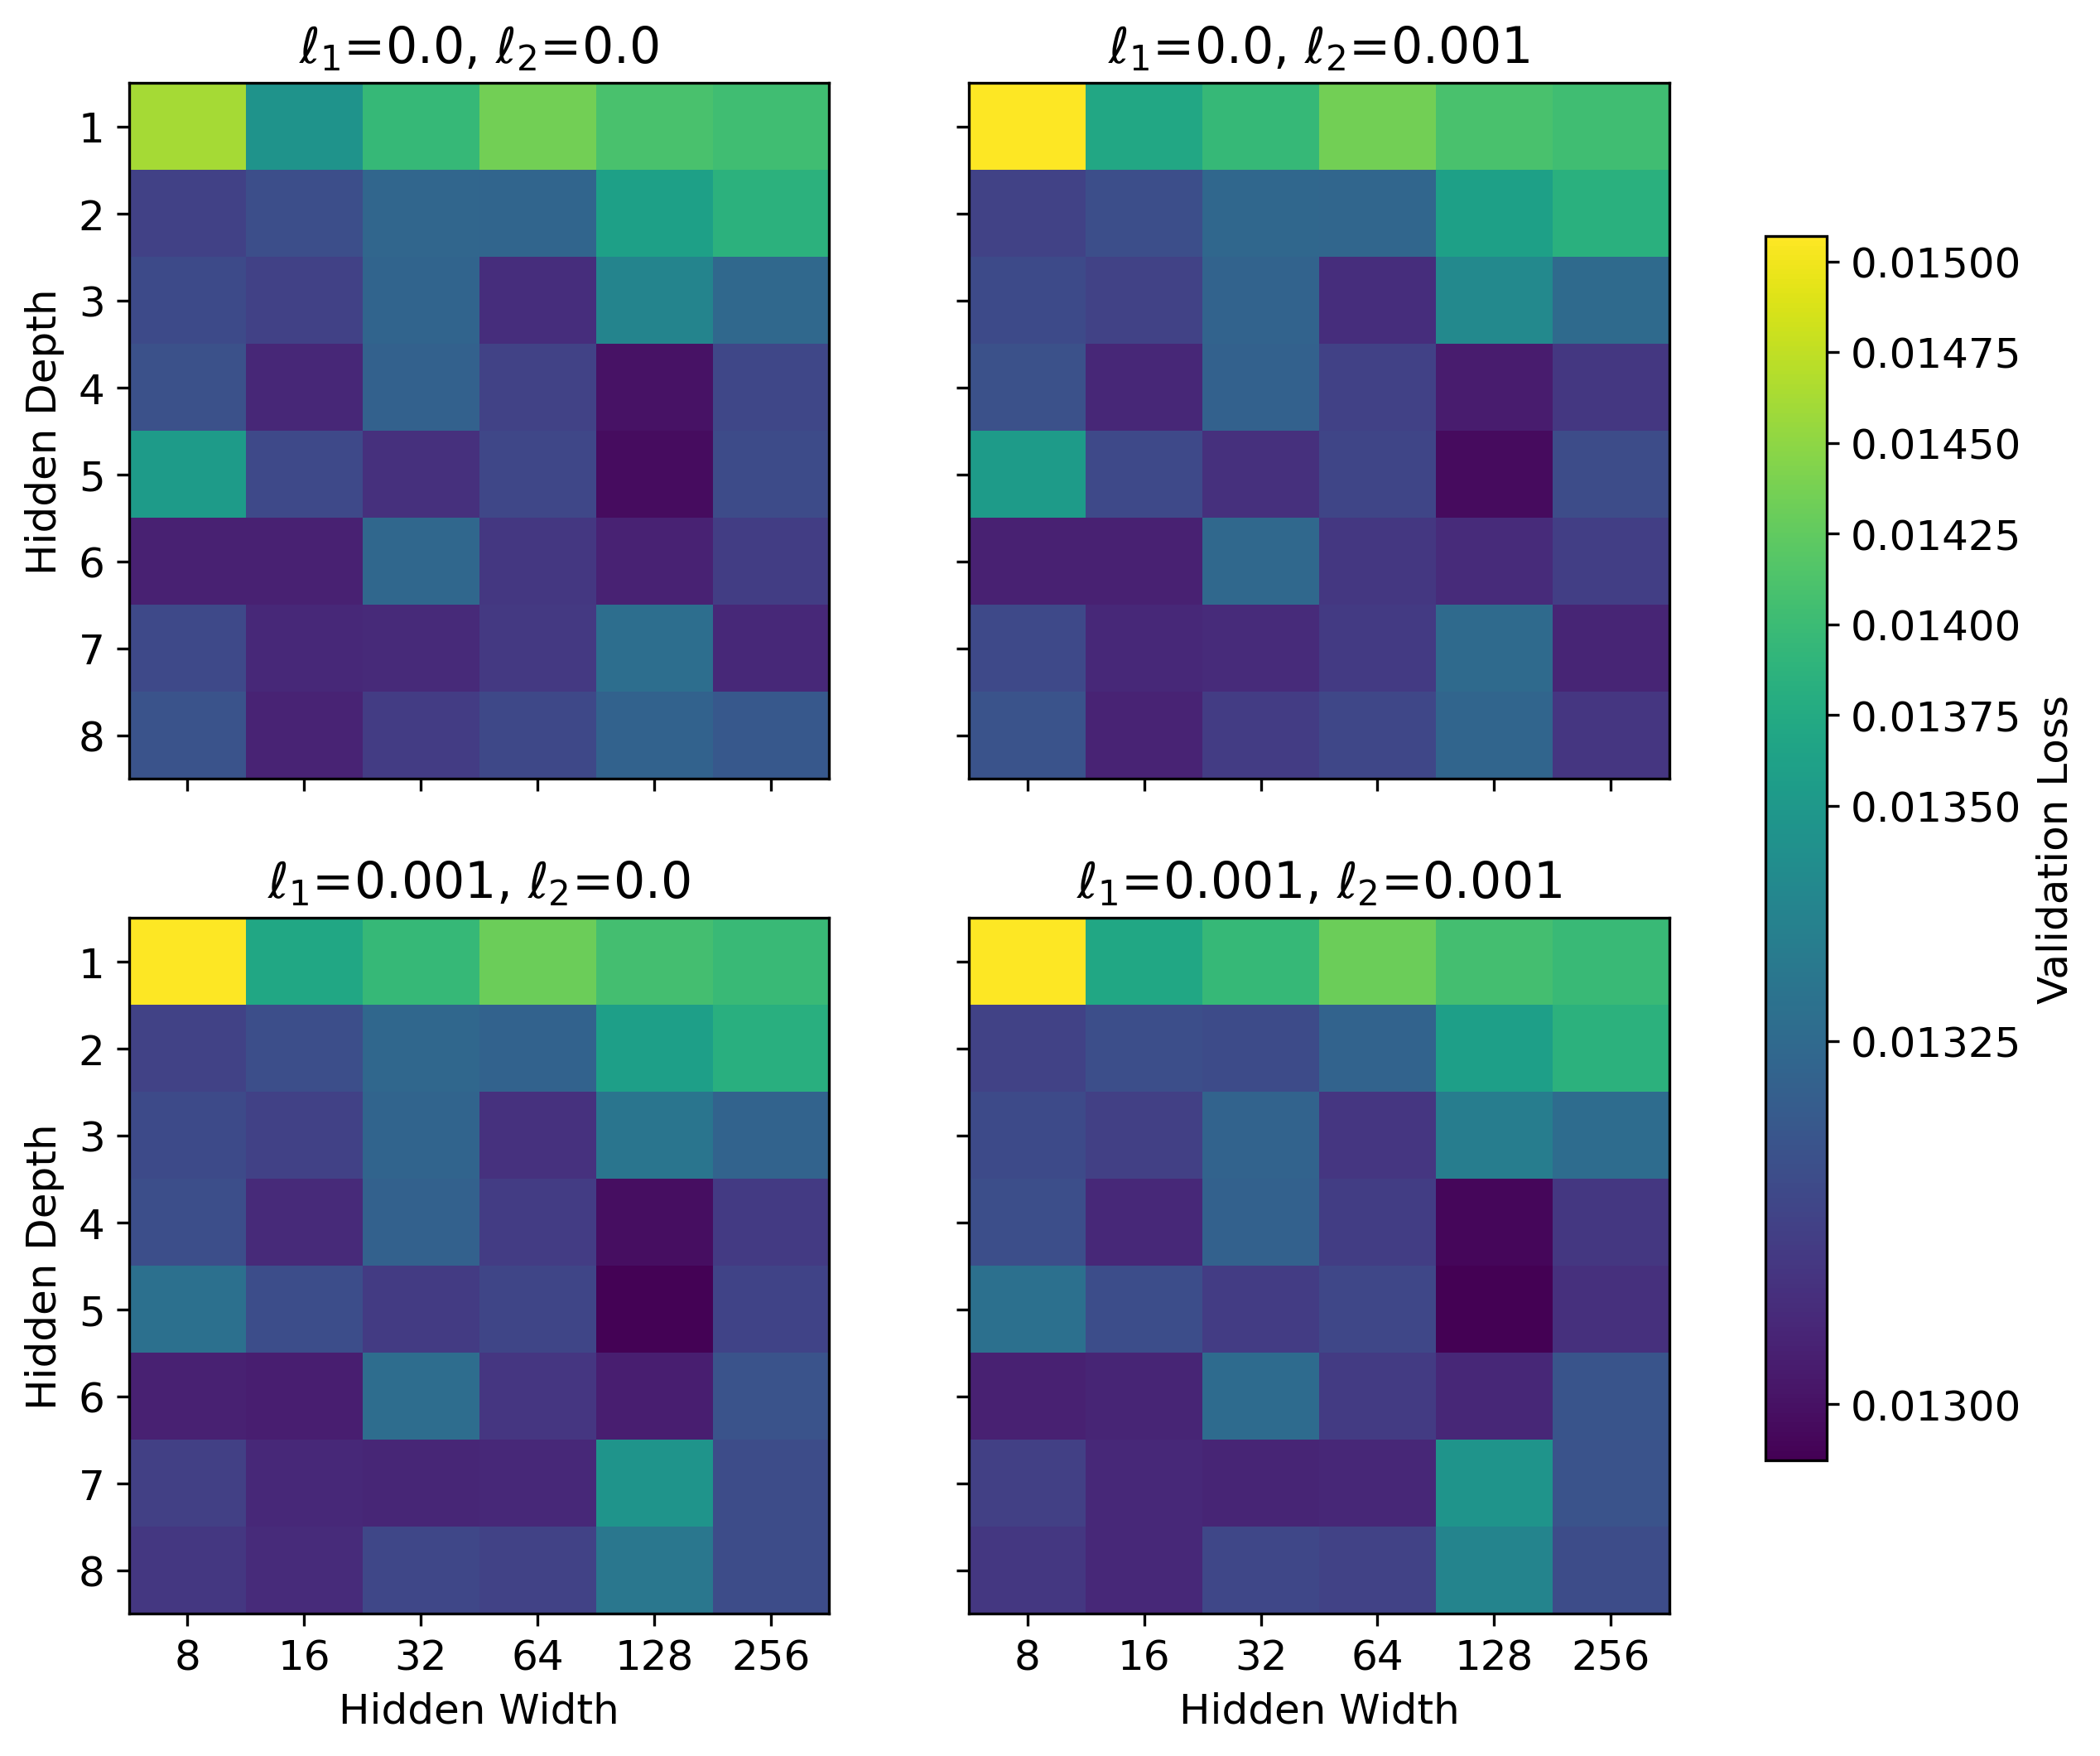

In [15]:
n_l1 = len(l1_space)
n_l2 = len(weight_decay_space)

# first pass: build and collect all the loss‐matrices so we can compute a global vmin/vmax
all_losses = []
loss_matrices = [[None]*n_l2 for _ in range(n_l1)]
for i, lambda_l1 in enumerate(l1_space):
    for j, weight_decay in enumerate(weight_decay_space):
        mat = np.zeros((len(depth_space), len(width_space)))
        for di, hidden_depth in enumerate(depth_space):
            for wj, hidden_width in enumerate(width_space):
                name = (
                    f"l1{lambda_l1}_l2{weight_decay}"
                    f"_drop{dropout_space[0]}_lr{learning_rate_space[0]}"
                    f"_w{hidden_width}_d{hidden_depth}"
                )
                model = best_models_23[name]
                model.eval()
                losses = []
                with torch.no_grad():
                    for Xb, yb in val_loader:
                        Xb, yb = Xb.to(device), yb.to(device)
                        yp     = model(Xb)
                        losses.append(criterion(yp, yb).item())
                mat[di, wj] = np.mean(losses)
        loss_matrices[i][j] = mat
        all_losses.append(mat)

# global min/max
vmin = np.min(all_losses)
vmax = np.max(all_losses)
# pick a center low in the range to "stretch" the bottom end
vcenter = vmin + 0.2*(vmax - vmin)

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'viridis'

fig, axes = plt.subplots(n_l1, n_l2, figsize=(5 * n_l2, 4 * n_l1), squeeze=False)

for i in range(n_l1):
    for j in range(n_l2):
        ax = axes[i, j]
        mat = loss_matrices[i][j]
        im = ax.imshow(mat, aspect='auto', cmap=cmap, norm=norm)

        # ticks & labels
        ax.set_xticks(np.arange(len(width_space)))
        ax.set_xticklabels(width_space)
        ax.set_yticks(np.arange(len(depth_space)))
        ax.set_yticklabels(depth_space)

        # only bottom row: show x-axis label
        if i == n_l1 - 1:
            ax.set_xlabel('Hidden Width')
        else:
            ax.tick_params(labelbottom=False)

        # only left column: show y-axis label
        if j == 0:
            ax.set_ylabel('Hidden Depth')
        else:
            ax.tick_params(labelleft=False)

        # title for each panel
        lambda_l1 = l1_space[i]
        weight_decay = weight_decay_space[j]
        ax.set_title(f"$\\ell_1$={lambda_l1}, $\\ell_2$={weight_decay}")

# shared colorbar
cbar = fig.colorbar(im, ax=axes.flatten().tolist(), shrink=0.8)
cbar.set_label('Validation Loss')

# plt.tight_layout()
plt.show()